In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt
import pymc3 as pm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from plotnine import *

In [7]:
plt.rcParams["font.family"] = "IPAGothic"

In [8]:
from IPython.display import display

def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [5]:
!ls -lh ../data/raw

total 13905344
drwxr-xr-x  4 localadmin  staff   128B May 16 15:25 CAN
-rwxr-xr-x@ 1 localadmin  staff   2.3G May  8 15:16 dbhaa0001_process_200301_200812.csv
-rwxr-xr-x@ 1 localadmin  staff   1.2G May  8 15:49 dbhaa0001_process_201501_201904.csv
-rwxr-xr-x@ 1 localadmin  staff   785M May  8 18:10 tbhaa0006_fcok_19940401_20000330.csv
-rwxr-xr-x@ 1 localadmin  staff   2.0G May  8 18:01 tbhaa0006_fcok_20000401_20060330.csv
-rwxr-xr-x@ 1 localadmin  staff   297M May  8 16:34 tbhaa0006_fcok_20180401_20190330.csv


In [9]:
df_process = pd.read_csv("../data/raw/dbhaa0001_process_201501_201904.csv")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,11,12,13,14,18,20,27,28,29,30,33,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df_process.shape

(4082108, 48)

In [11]:
memory_usage = df_process.memory_usage()
memory_usage.sum()

1567529552

In [16]:
memory_usage.sum() / 1e9 # GB

1.567529552

## 処理日ベース、処理数ベース

In [104]:
n_proc_byM = df_process.groupby("W_PROCESS_MONTH")["W_VIN"].apply(len).to_frame()
n_proc_byM["N_VIN"] = df_process.groupby("W_PROCESS_MONTH")["W_VIN"].nunique()

n_proc_byM = n_proc_byM.reset_index()

n_proc_byM["W_PROCESS_MONTH_DT"] = pd.to_datetime(n_proc_byM["W_PROCESS_MONTH"].astype(str) + "01")
n_proc_byM.rename(columns={"W_VIN":"N_W"},inplace=True)

Text(0, 0.5, 'number of warranty')

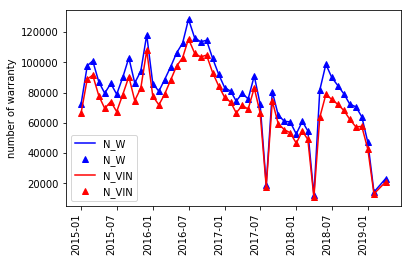

In [116]:
fig, ax1 = plt.subplots()
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_W , 'b-')       
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_W,'b^')
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_VIN , 'r-')       
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_VIN,'r^')
plt.legend()
fig.autofmt_xdate(rotation=90)
ax1.set_ylabel("number of warranty")

In [117]:
n_proc_byM.sort_values(by="N_W").head()

,W_PROCESS_MONTH,N_W,N_VIN,W_PROCESS_MONTH_DT
39,201804,12049,10825,2018-04-01
49,201902,14265,13084,2019-02-01
31,201708,19199,17840,2017-08-01
50,201904,23083,20895,2019-04-01
48,201901,47012,42396,2019-01-01


2017年8月、2018年4月、2019年1~2月が極端に少ない。

In [119]:
from pandas.plotting import autocorrelation_plot
n_proc_byM.set_index("W_PROCESS_MONTH_DT", inplace=True)

KeyError: "['W_PROCESS_MONTH_DT']"

Text(0.5, 1.0, 'autocorrelation of number of warranty per month')

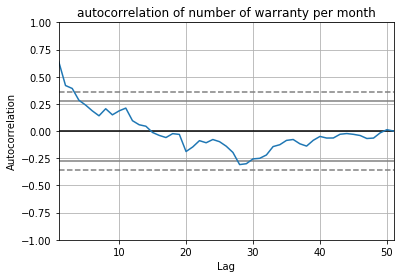

In [121]:
autocorrelation_plot(n_proc_byM.N_W)
plt.title("autocorrelation of number of warranty per month")

Text(0.5, 1.0, 'autocorrelation of change of number of warranty per month')

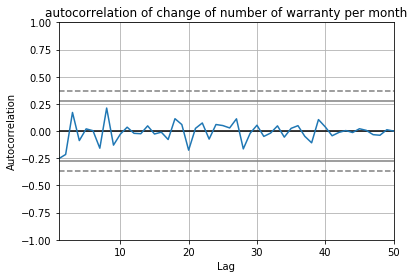

In [123]:
autocorrelation_plot(n_proc_byM.N_W.diff().dropna())
plt.title("autocorrelation of change of number of warranty per month")

In [3]:
df_process["W_PROCESS_MONTH_TYPE"] = df_process.W_PROCESS_MONTH.astype(str).str[4:]

n_proc_byM = df_process.groupby(["W_PROCESS_MONTH","W_PROCESS_MONTH_TYPE"])["W_VIN"].apply(len).to_frame()
n_proc_byM = n_proc_byM.reset_index()
n_proc_byM["W_PROCESS_MONTH_DT"] = pd.to_datetime(n_proc_byM["W_PROCESS_MONTH"].astype(str) + "01")
n_proc_byM.rename(columns={"W_VIN":"N_W"},inplace=True)

n_proc_byM["W_PROCESS_YEAR"] = n_proc_byM["W_PROCESS_MONTH"].astype(str).str[:4]

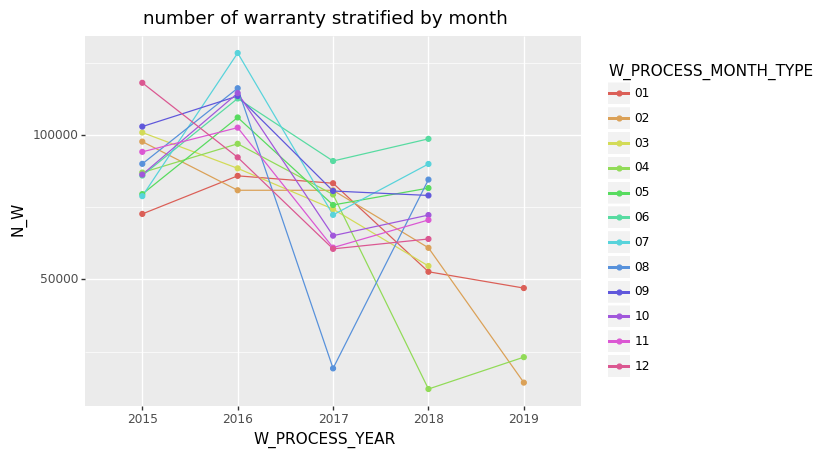

<ggplot: (304762211)>

In [47]:
g = (ggplot(n_proc_byM.drop("W_PROCESS_MONTH", axis=1), 
            aes(x="W_PROCESS_YEAR", y="N_W",color="W_PROCESS_MONTH_TYPE", group="W_PROCESS_MONTH_TYPE")) 
     + geom_line()
     + geom_point()
     + ggtitle("number of warranty stratified by month"))
g

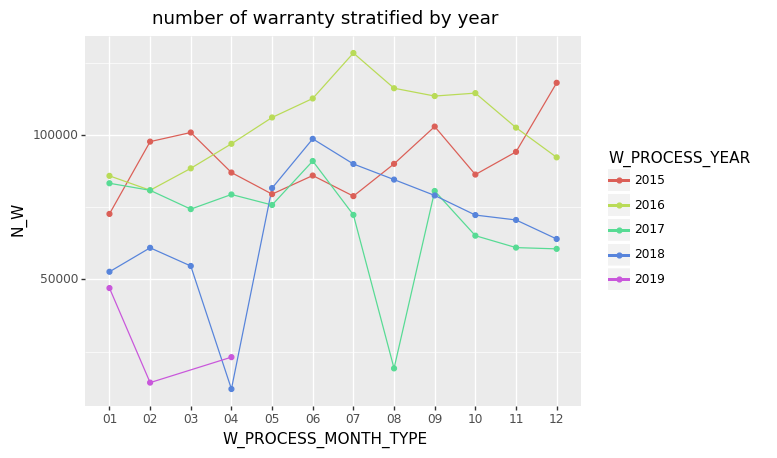

<ggplot: (-9223372036542946574)>

In [48]:
g = (ggplot(n_proc_byM.drop("W_PROCESS_MONTH", axis=1), 
            aes(x="W_PROCESS_MONTH_TYPE", y="N_W",color="W_PROCESS_YEAR", group="W_PROCESS_YEAR")) 
     + geom_line()
     + geom_point()
     + ggtitle("number of warranty stratified by year"))
g

単純にワランティ数だけでは、季節性は見えてこない

## 故障日ベース、処理数ベース

In [10]:
df_process["W_FAILURE_YM"] = df_process["W_FAILURE_DATE"].astype(str).str[:6]

In [63]:
display_all(df_process.W_FAILURE_YM.value_counts().sort_index().to_frame().T)

,0,1,10,11,12,13,14,15,16,17,18,19,20,200410,200411,200412,200502,200503,200504,200505,200512,200602,200606,200701,200702,200703,200704,200710,200711,200801,200802,200803,200806,200807,200809,200810,200812,200902,200908,201002,201004,201006,201007,201008,201009,201011,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201111,201112,201201,201202,201204,201205,201206,201207,201208,201209,201210,201212,201301,201302,201303,201304,201305,201306,201307,201308,201309,201310,201311,201312,201401,201402,201403,201404,201405,201406,201407,201408,201409,201410,201411,201412,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,21,22,24,26,27,28,3,30,32,50,52,8,9
W_FAILURE_YM,11804,5,136,4,5,5,4,2,7,2,9,3,11,2,3,2,1,2,2,1,3,2,2,2,1,1,1,1,1,1,1,1,3,1,1,1,2,1,1,2,2,1,2,1,1,1,5,3,2,5,2,1,3,4,6,5,4,1,2,3,1,8,4,1,4,3,8,9,3,13,6,5,3,9,16,6,11,16,21,25,69,41,42,55,76,79,145,291,770,1904,16954,57636,84818,97454,91688,78497,80360,81413,94809,87957,95035,86323,101215,106190,82159,86181,103628,105100,111435,129089,131332,113601,109424,97864,94299,81859,77121,70690,82809,75553,83434,68622,44936,60977,68469,60714,61283,50526,54976,51849,34965,65953,97588,88527,91457,74978,73352,72978,60327,42566,21798,1801,15527,6248,3,6,5,2,1,2,1,1,1,2,1,1,1


入力ミスや0で入力されている値がそれなりに多そうだ。

In [11]:
vc_len = df_process.W_FAILURE_DATE.astype(str).str.len()

In [12]:
idx_err = np.where(vc_len!=8)[0]

In [13]:
df_process["W_FAILURE_DATE"].iloc[idx_err].value_counts()

0     11804
10      136
20       11
18        9
16        7
22        6
13        5
24        5
12        5
1         5
14        4
11        4
21        3
19        3
17        2
15        2
26        2
50        2
28        2
30        1
9         1
27        1
32        1
52        1
8         1
3         1
Name: W_FAILURE_DATE, dtype: int64

これらの数字の入っている列は除外する。

In [14]:
df_process.drop(idx_err, inplace=True)

In [92]:
df_process.shape

(4070084, 50)

In [11]:
n_fail_byM = df_process.groupby("W_FAILURE_YM")["W_VIN"].apply(len).to_frame()
n_fail_byM["N_VIN"] = df_process.groupby("W_FAILURE_YM")["W_VIN"].nunique()
n_fail_byM = n_fail_byM.reset_index()
n_fail_byM.rename(columns={"W_VIN":"N_W"},inplace=True)

In [12]:
n_fail_byM["W_FAILURE_YM_DT"] = pd.to_datetime(n_fail_byM["W_FAILURE_YM"].astype(str) + "01")

In [13]:
n_fail_byM_lim = n_fail_byM[n_fail_byM.W_FAILURE_YM_DT >= pd.to_datetime("20150101")]

Text(0, 0.5, 'number of warranty')

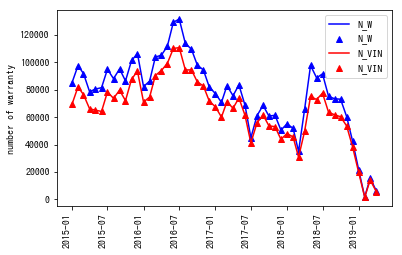

In [14]:
fig, ax1 = plt.subplots()
ax1.plot(n_fail_byM_lim.W_FAILURE_YM_DT, n_fail_byM_lim.N_W , 'b-')       
ax1.plot(n_fail_byM_lim.W_FAILURE_YM_DT, n_fail_byM_lim.N_W,'b^')
ax1.plot(n_fail_byM_lim.W_FAILURE_YM_DT, n_fail_byM_lim.N_VIN , 'r-')       
ax1.plot(n_fail_byM_lim.W_FAILURE_YM_DT, n_fail_byM_lim.N_VIN,'r^')
plt.legend()
fig.autofmt_xdate(rotation=90)
ax1.set_ylabel("number of warranty")

In [5]:
n_fail_byM_lim.N_W.plot()
plt.xlabel("故障月")
plt.ylabel("ワランティ数")

NameError: name 'n_fail_byM_lim' is not defined

In [1]:
model = """data {
  int<lower=1> n;
  int<lower=1> m;
  int<lower=1> c;
  vector[n] y;
}
parameters {
  vector[n] mu;
  vector[n] seasonal;
  real<lower=0> sigma_level;
  real<lower=0> sigma_seas;
  real<lower=0> sigma_irreg;
}
transformed parameters {
  vector[n] yhat;
  yhat = mu + seasonal;
}
model {
  for(t in c:n)
    seasonal[t] ~ normal(- sum(seasonal[(t-c+1):t-1]), sigma_seas);

  for(t in 3:n)
    mu[t] ~ normal(2 * mu[t-1] - mu[t-2], sigma_level);

  y ~ normal(yhat, sigma_irreg);
}

generated quantities {
    vector[n + m] seasonal_pred;
    vector[n + m] mu_pred;
    vector[m] y_pred;
    seasonal_pred[1:n] = seasonal;
    mu_pred[1:n] = mu;

    for (t in 1:m) {
        seasonal_pred[n+t] = normal_rng(- sum(seasonal_pred[(n+t-c+1):(n+t-1)]), sigma_seas);
        mu_pred[n+t] = normal_rng(2 * mu_pred[n+t-1] - mu_pred[n+t-2] , sigma_level);
        y_pred[t] = normal_rng(mu_pred[n+t] + seasonal_pred[n+t], sigma_irreg);
    }
    
}
"""

In [2]:
import pystan

In [3]:
%%time
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5cf23dee4fb5925c46b308f5d11f980d NOW.


CPU times: user 991 ms, sys: 61.4 ms, total: 1.05 s
Wall time: 42.3 s


In [4]:
%%time
y = n_fail_byM_lim.N_W.values
dat = {"y": y,
      "n": len(y),
      "m":12,
      "c":12}
fit = sm2.sampling(data=dat, iter=1000, chains=4)

NameError: name 'n_fail_byM_lim' is not defined

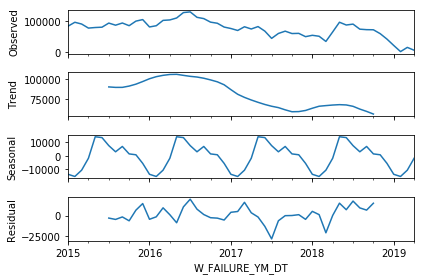

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(n_fail_byM_lim.N_W, model='additive')
result.plot()
plt.show()

Text(0, 0.5, 'number of warranty')

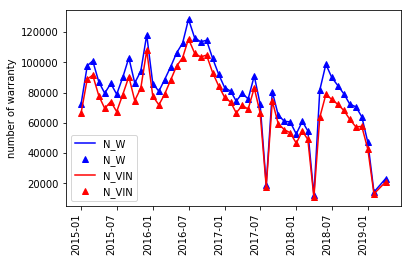

In [105]:
fig, ax1 = plt.subplots()
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_W , 'b-')       
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_W,'b^')
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_VIN , 'r-')       
ax1.plot(n_proc_byM.W_PROCESS_MONTH_DT, n_proc_byM.N_VIN,'r^')
plt.legend()
fig.autofmt_xdate(rotation=90)
ax1.set_ylabel("number of warranty")

全体の傾向は変わらないが、2017年, 2018年の急激な落ち込みはなくなる

In [127]:
n_proc_byM.set_index("W_PROCESS_MONTH_DT", inplace=True)

In [129]:
n_proc_byM.N_W.head()

W_PROCESS_MONTH_DT
2015-01-01     72691
2015-02-01     97733
2015-03-01    100888
2015-04-01     87018
2015-05-01     79549
Name: N_W, dtype: int64

In [132]:
n_proc_byM.index

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-04-01'],
              dtype='datetime64[ns]', name='W_PROCESS_MONTH_DT', freq=None)

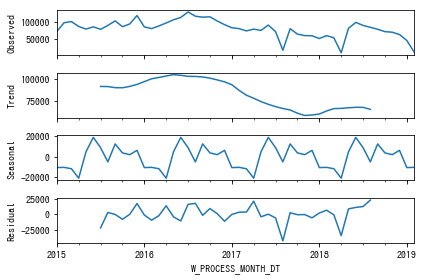

In [133]:
result = seasonal_decompose(n_proc_byM.N_W[:-1], model='additive')
result.plot()
plt.show()

In [107]:
n_fail_byM_lim.sort_values(by="N_W").head(7)

,W_FAILURE_YM,N_W,N_VIN,W_FAILURE_YM_DT
128,201902,1801,1662,2019-02-01
130,201904,6248,5691,2019-04-01
129,201903,15527,14130,2019-03-01
127,201901,21798,19818,2019-01-01
117,201803,34965,30744,2018-03-01
126,201812,42566,38427,2018-12-01
109,201707,44936,41140,2017-07-01


In [108]:
n_fail_byM_lim.set_index("W_FAILURE_YM_DT", inplace=True)

In [110]:
from pandas.plotting import autocorrelation_plot

Text(0.5, 1.0, 'autocorrelation of number of warranty per month')

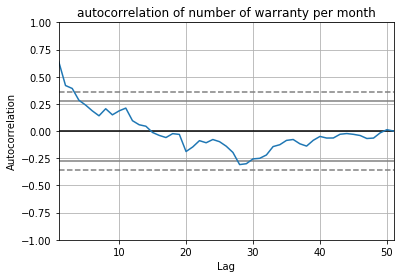

In [111]:
autocorrelation_plot(n_proc_byM.N_W)
plt.title("autocorrelation of number of warranty per month")

Text(0.5, 1.0, 'autocorrelation of change of number of warranty per month')

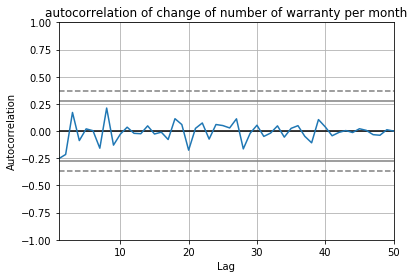

In [112]:
autocorrelation_plot(n_proc_byM.N_W.diff().dropna())
plt.title("autocorrelation of change of number of warranty per month")

同じような傾向

In [ ]:
df_process["W_PROCESS_MONTH_TYPE"] = df_process.W_PROCESS_MONTH.astype(str).str[4:]

n_proc_byM = df_process.groupby(["W_PROCESS_MONTH","W_PROCESS_MONTH_TYPE"])["W_VIN"].apply(len).to_frame()
n_proc_byM = n_proc_byM.reset_index()
n_proc_byM["W_PROCESS_MONTH_DT"] = pd.to_datetime(n_proc_byM["W_PROCESS_MONTH"].astype(str) + "01")
n_proc_byM.rename(columns={"W_VIN":"N_W"},inplace=True)

n_proc_byM["W_PROCESS_YEAR"] = n_proc_byM["W_PROCESS_MONTH"].astype(str).str[:4]

In [ ]:
g = (ggplot(n_proc_byM.drop("W_PROCESS_MONTH", axis=1), 
            aes(x="W_PROCESS_YEAR", y="N_W",color="W_PROCESS_MONTH_TYPE", group="W_PROCESS_MONTH_TYPE")) 
     + geom_line()
     + geom_point()
     + ggtitle("number of warranty stratified by month"))
g

In [ ]:
g = (ggplot(n_proc_byM.drop("W_PROCESS_MONTH", axis=1), 
            aes(x="W_PROCESS_MONTH_TYPE", y="N_W",color="W_PROCESS_YEAR", group="W_PROCESS_YEAR")) 
     + geom_line()
     + geom_point()
     + ggtitle("number of warranty stratified by year"))
g

In [72]:
display_all(df_process.head())

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
0,WRJPJP201504B001202,100100,100100.0,1,B,0,201504,40223,JP,15C0100551,1.0,15,1,0,NaN,1,1,1,201504006777793,MH34S-702672,20120901,YV0E1B9J,20120928,20150323,K,16283,72350-72M02,99,76,24,9,NaN,NaN,NaN,910,0.2,1240,0.0,0,0,2150,3116,30,514,30,30,NaN,17-06-19 18:05:50.068344000
1,WRJPJP201504B001203,100100,100100.0,1,B,0,201504,40223,JP,15C0105891,1.0,15,1,0,NaN,1,1,1,201504006776105,MH34S-718306,20130101,YV0E1B9J,20130214,20150324,K,10433,72350-72M02,99,65,24,1,NaN,NaN,NaN,910,0.2,1240,0.0,0,0,2150,3116,30,514,26,26,NaN,17-06-19 18:05:50.071115000
2,WRJPJP201504B001204,100100,100100.0,1,B,0,201504,50224,JP,15D0054801,1.0,22,4,0,NaN,1,1,1,201504006791151,MH23S-837237,20100101,YG0B1B9D,20100129,20150413,K,43200,17931-58J01,99,85,29,4,NaN,NaN,NaN,878,0.2,1280,0.0,0,0,2158,3978,0,0,63,63,NaN,17-06-19 18:05:50.073222000
3,WRJPJP201504B001205,100100,100100.0,1,B,0,201504,50224,JP,15C0085531,1.0,78,1,0,NaN,1,1,1,201504006770379,MH23S-668540,20120401,YG0A2B9D,20120420,20150327,K,21877,17931-58J01,32,85,23,8,NaN,NaN,NaN,878,0.2,1280,0.0,0,0,2158,3978,50,783,35,36,NaN,17-06-19 18:05:50.075672000
4,WRJPJP201504B001206,100100,100100.0,1,B,0,201504,50224,JP,15C0057741,1.0,6,4,0,NaN,1,1,1,201504006772241,MK21S-197951,20100401,YT212B9F,20100409,20150313,K,32461,17931-58J01,99,85,29,8,NaN,NaN,NaN,878,0.2,1280,0.0,0,0,2158,3978,0,0,59,60,NaN,17-06-19 18:05:50.077429000


In [77]:
n_w_byVIN = df_process.W_VIN.value_counts()

In [80]:
n_w_byVIN.head(5)

MR31S-801974    53
ZC32S-310302    45
MH34S-944526    35
MR41S-117895    32
MH34S-935628    28
Name: W_VIN, dtype: int64

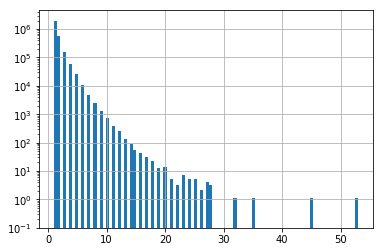

In [85]:
fig, ax = plt.subplots()
n_w_byVIN.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

同一車体でも、複数パーツ交換する場合がそれなりにある。

In [86]:
n_w_by_parts = df_process.W_CAUSAL_PART_NO.value_counts()

In [87]:
n_w_by_parts.head()

95410-82KV0        85209
85104-82K13-RX0    82626
37111-78A20-RX0    81640
95411-82K11        76125
85170-62810-RX0    72854
Name: W_CAUSAL_PART_NO, dtype: int64

In [99]:
df_process_95410 = df_process[df_process.W_CAUSAL_PART_NO == '95410-82KV0']

In [100]:
df_process_95410.head()

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,...,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
1082171,WRJPJP201604B024401,100100,100100.0,1,B,0,201604,50311,JP,16C0197281,...,0,0,14591,3894,0,0,78,79,NaN,17-06-19 19:28:36.790662000
1135791,WRJPJP201604B031388,100100,100100.0,1,B,0,201604,50404,JP,16D0046771,...,0,0,33670,3894,0,0,75,74,NaN,17-06-19 19:28:52.232422000
1135793,WRJPJP201604B031390,100100,100100.0,1,B,0,201604,30202,JP,16D0057081,...,0,0,33700,3894,0,0,85,84,NaN,17-06-19 19:28:52.236952000
1135797,WRJPJP201604B031394,100100,100100.0,1,B,0,201604,50516,JP,16C0007531,...,0,0,33700,3894,0,0,83,83,NaN,17-06-19 19:28:52.246086000
1135905,WRJPJP201604B033301,100100,100100.0,1,B,0,201604,50116,JP,16D0023511,...,0,0,44191,3894,46,16347,23,21,NaN,17-06-19 19:28:56.223054000
